In [ ]:
!pip install gymnasium matplotlib numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Imports
import cv2
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

In [ ]:
#!pip install gymnasium matplotlib numpy
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Defining the Car Expedition Environment.
class ExpeditionEnvironment(gym.Env):
    """This class implements the Wumpus World environment."""

    def __init__(self, environment_type):
        """This method initializes the environment.

        :param str environment_type: - It can take two values: 1. 'deterministic' 2. 'stochastic'
                                       indicating the type of environment."""

        self.environment_type = environment_type

        self.environment_width = 4
        self.environment_height = 4

        #Rewards Section
        self.rewards = np.array([2,6,2,9,2,3,4])
        self.penalty= np.array([-3,-4])
        self.final_rewards=0


        self.observation_space = spaces.Discrete(self.environment_width * self.environment_height)
        self.action_space = spaces.Discrete(4)

        #positions of car, fuel, hotel and rocks
        self.car_pos = np.asarray([0, 0])
        self.fuel_pos = np.asarray([[1, 0], [3, 0], [2, 1], [1, 2], [3, 2],  [0, 3], [2, 3]])
        self.hotel_pos = np.asarray([3, 3])
        self.hotel_quantity = 1
        self.rock_pos = np.asarray([[2, 0], [2, 2],[1,3]])


        self.state = np.zeros((self.environment_width,self.environment_height))

        #to store the total reward per episode
        self.reward=0

        #for termination
        self.max_timesteps = 10
        self.timestep =0

    def reset(self):
        """This method resets the car position and returns the state as the observation.

        :returns int observation: -  Integer representing the grid block the car is in.
                 dict info: - A dictionary that can be used to provide additional implementation information."""

        #when and all this function will be called -after every episode it seems ..
        self.state = np.zeros((self.environment_width,self.environment_height))

        #positions of car, fuel, hotel and rocks
        self.car_pos = np.asarray([0, 0])
        self.fuel_pos = np.asarray([[1, 0], [3, 0], [2, 1], [1, 2], [3, 2],  [0, 3],[2, 3]])
        self.hotel_pos = np.asarray([3, 3])
        self.hotel_quantity = 1
        self.rock_pos = np.asarray([[2, 0], [2, 2]])


        #to store the total reward per episode
        self.rewards = np.array([2,6,2,9,2,3,4])
        self.penalty= np.array([-3,-4])

        #Return the action
        observation= self.state.flatten()
        # return observation
        return self.car_pos


    action_val=""
    def step(self, action):
        """This method implements what happens when the car takes a particular action. It changes the car's
        position (While not allowing it to go out of the environment space.), maps the environment co-ordinates to a
        state, defines the rewards for the various states, and determines when the episode ends.

        :param int action: - Integer in the range 0 to 3 inclusive representing the different actions the car can
        take.

        :returns arr observation: - Array representing the partial observation.
                 int reward: - Integer value that's used to measure the performance of the car.
                 bool terminated: - Boolean describing whether the episode has ended.
                 bool truncated: Boolean describing whether a truncation condition outside the scope of the MDP is
                                 satisfied.
                 dict info: - A dictionary that can be used to provide additional implementation information."""

        # Describing the outcomes of the various possible actions.
        if action == 0:
            self.car_pos[0] += 1  # This action causes the car to go right.
            action_val= "Right"
            print("Action taken by the car: Right")
        if action == 1:
            self.car_pos[0] -= 1  # This action causes the car to go left.
            action_val= "Left"
            print("Action taken by the car: Left")
        if action == 2:
            action_val= "Up"
            self.car_pos[1] +=1  # This action causes the car to go up.
            print("Action taken by the car: Up")
        if action == 3:
            action_val= "Down"
            self.car_pos[1] -=1  # This action causes the car to go down.
            print("Action taken by the car: Down")

        # self.car_pos=np.clip(self.car_pos,0,2)#limiting the movement of the car

        #new logic to limit the movement of car , for negative indexes
        # Define the limits of the valid range for the car position

        if self.car_pos[0]<0:
           self.car_pos[0]=0
        elif self.car_pos[0]>3:
           self.car_pos[0]=3
        if self.car_pos[1]<0:
           self.car_pos[1]=0
        if self.car_pos[1]>3:
           self.car_pos[1]=3





        if self.car_pos[0]==0:
          x_min=0
          x_max=self.car_pos[0]+1
        elif self.car_pos[0]==3:
          x_min=self.car_pos[0]-1
          x_max=3
        else:
          x_min=self.car_pos[0]-1
          x_max=self.car_pos[0]+1

        if self.car_pos[1]==0:
          y_min=0
          y_max=self.car_pos[1]+1
        elif self.car_pos[1]==3:
          y_min=self.car_pos[1]-1
          y_max=3
        else:
          y_min=self.car_pos[1]-1
          y_max=self.car_pos[1]+1

        # Apply the clip function to limit the car position to the valid range

        self.car_pos[0] = np.clip(self.car_pos[0], x_min, x_max)
        self.car_pos[1] = np.clip(self.car_pos[1], y_min, y_max)
        observation = self.state.flatten()



        self.timestep+=1

        #this variable keeps track of every episode
        terminated=True if self.timestep>=self.max_timesteps else False

        #set terminated true if car reached hotel
        if np.array_equal(self.car_pos,self.hotel_pos):
          terminated=True

        #Rewards and Penalty
        for i in range(len(self.fuel_pos)):
          if np.array_equal(self.car_pos, self.fuel_pos[i]):
            self.final_rewards+=self.rewards[i]

        for i in range(len(self.rock_pos)):
          if np.array_equal(self.car_pos, self.rock_pos[i]):
            self.final_rewards+=self.penalty[i]

        truncated= True if np.all((self.car_pos>=0 ) & (self.car_pos<=2)) else False

        # return observation , self.reward , terminated , truncated #because sarsa gives error when returning the whole obs space
        return self.car_pos , self.final_rewards , terminated , truncated

    def render(self, mode='human', plot=False):
        """This method renders the environment.

        :param str mode: 'human' renders to the current display or terminal and returns nothing.
        :param bool plot: Boolean indicating whether we show a plot or not. If False, the method returns a resized NumPy
                     array representation of the environment to be used as the state. If True it plots the environment.

        :returns arr preprocessed_image: Grayscale NumPy array representation of the environment."""

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim(0, 3)
        ax.set_ylim(0, 3)

        def plot_image(plot_pos):
            """This is a helper function to render the environment. It checks which objects are in a particular
            position on the grid and renders the appropriate image.

            :param arr plot_pos: Co-ordinates of the grid position which needs to be rendered."""

            # Initially setting every object to not be plotted.
            plot_car, plot_fuel, plot_hotel, plot_rock = \
                False, False, False, False

            # Checking which objects need to be plotted by comparing their positions.
            if np.array_equal(self.car_pos, plot_pos):

                plot_car = True
            if any(np.array_equal(self.fuel_pos[i], plot_pos) for i in range(len(self.fuel_pos))):

                plot_fuel = True
            if self.hotel_quantity > 0:  # Hotel isn't plotted if it has already been reached by one of the cars->there is only one car?
                if np.array_equal(plot_pos, self.hotel_pos):

                    plot_hotel = True
            if any(np.array_equal(self.rock_pos[i], plot_pos) for i in range(len(self.rock_pos))):

                plot_rock = True


            # Plot for Car.
            if plot_car and \
                    all(not item for item in
                        [plot_fuel, plot_hotel, plot_rock]):
                car = AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/images/car_normal.png'), zoom=0.03),
                                       np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(car)

            # Plot for Fuel.
            elif plot_fuel and \
                    all(not item for item in
                        [plot_car, plot_hotel, plot_rock]):
                fuel = AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/images/fuel_reward.jpg'), zoom=0.11),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(fuel)

            # Plot for Hotel.
            elif plot_hotel and \
                    all(not item for item in
                        [plot_car, plot_fuel, plot_rock]):
                hotel = AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/images/hotel.png'), zoom=0.11),
                                      np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(hotel)

            # Plot for Rock.
            elif plot_rock and \
                    all(not item for item in
                        [plot_car, plot_fuel, plot_hotel]):
                rock = AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/images/rock.jpg'), zoom=0.11),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(rock)

            # Plot for Hotel and Car-GOAL.
            elif all(item for item in [plot_car, plot_hotel]) and \
                    all(not item for item in
                        [plot_fuel, plot_rock]):
                car_reached = AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/images/car_hotel.png'), zoom=0.03),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)

                ax.add_artist(car_reached)




            # Plot for Car and Fuel.
            elif all(item for item in [plot_car, plot_fuel]) and \
                    all(not item for item in
                        [plot_hotel, plot_rock]):
                car_fuel = AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/images/car_fuelled.png'), zoom=0.11),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)

                ax.add_artist(car_fuel)

                #if car position ==fuel position just take the position out of the fuel array

                for i in range(self.fuel_pos.shape[0]):
                  if np.array_equal(self.fuel_pos[i], self.car_pos):
                    self.fuel_pos = np.delete(self.fuel_pos, i, axis=0)
                    break


            # Plot for Car and Rock.
            elif all(item for item in [plot_car, plot_rock]) and \
                    all(not item for item in
                        [plot_fuel, plot_hotel]):
                car_rock = AnnotationBbox(OffsetImage(plt.imread('/content/drive/MyDrive/images/car_hit_rock.jpg'), zoom=0.11),
                                           np.add(plot_pos, [0.5, 0.5]), frameon=False)

                ax.add_artist(car_rock)

                #if car position ==rock position just take the position out of the rock array
                print("self.car_pos",self.car_pos[0],self.car_pos[1])
                for i in range(self.rock_pos.shape[0]):
                  if np.array_equal(self.rock_pos[i], self.car_pos):
                    self.rock_pos = np.delete(self.rock_pos, i, axis=0)
                    break


        coordinates_state_mapping_2 = {}
        for j in range(self.environment_height * self.environment_width):
            coordinates_state_mapping_2[j] = np.asarray(
                [j % self.environment_width, int(np.floor(j / self.environment_width))])

        # Rendering the images for all states.
        for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])

        plt.xticks([0, 1, 2, 3,4])
        plt.yticks([0, 1, 2, 3,4])
        plt.grid()

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 84
            height = 84
            dim = (width, height)
            # noinspection PyUnresolvedReferences
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()
            return preprocessed_image









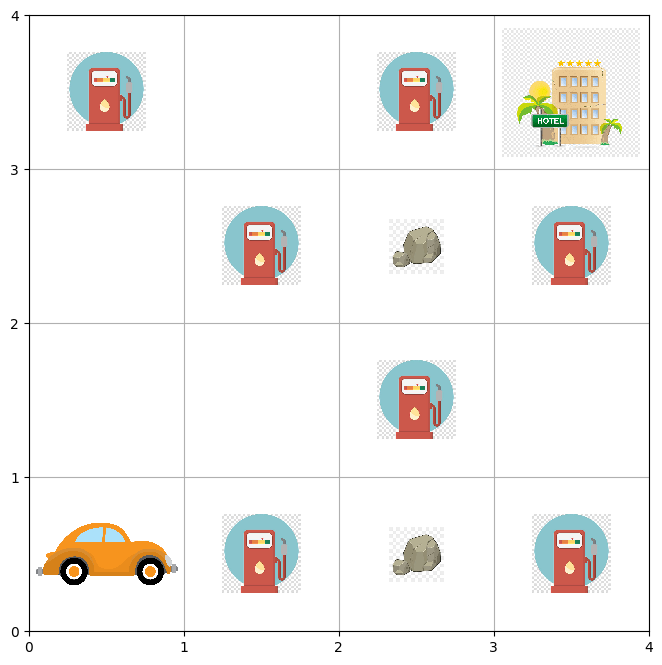

In [ ]:
car_move = ExpeditionEnvironment(environment_type='deterministic')
car_move.reset()
car_move.render(plot=True)


Action taken by the car: Up
The state of the car is: [0 1]
Reward for this step is:  0


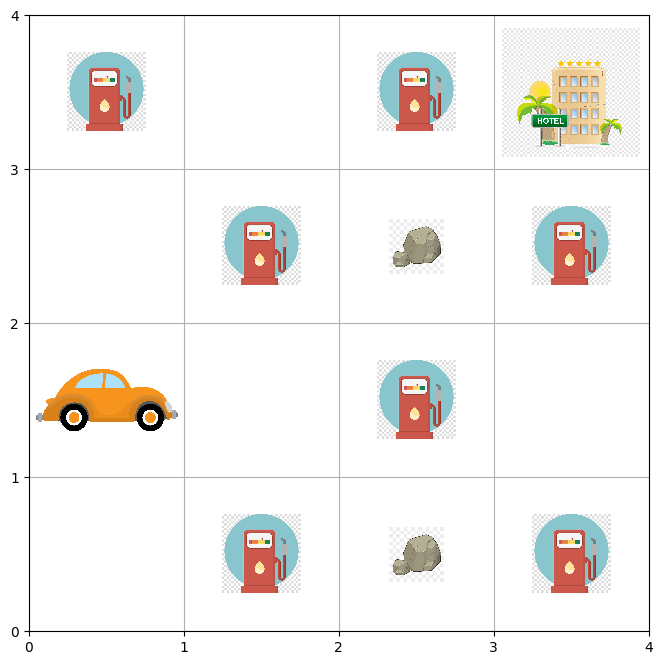

Action taken by the car: Up
The state of the car is: [0 2]
Reward for this step is:  0


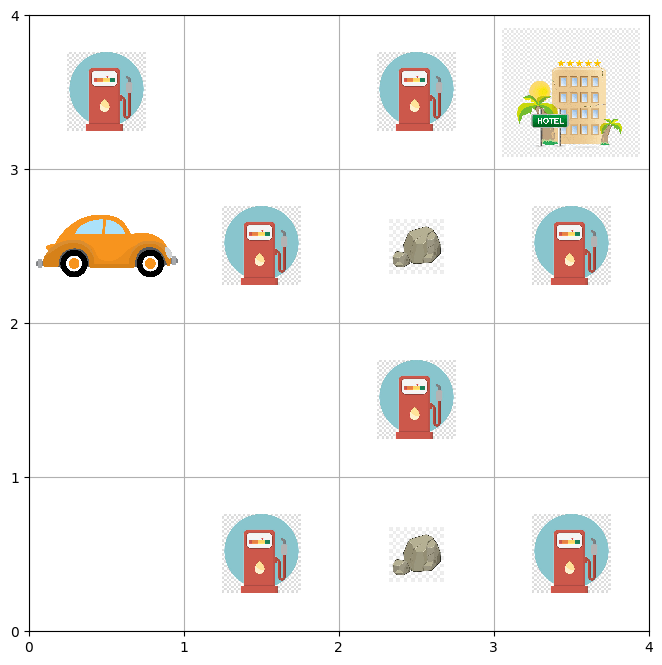

Action taken by the car: Down
The state of the car is: [0 1]
Reward for this step is:  0


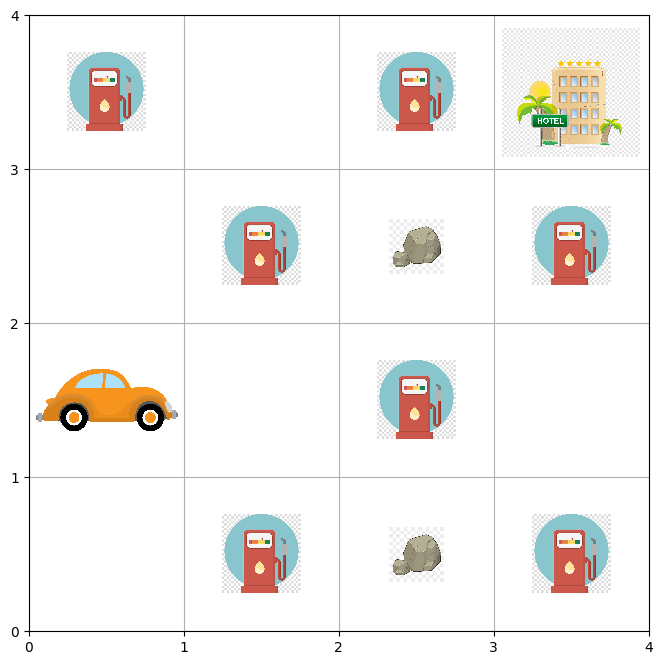

Action taken by the car: Right
The state of the car is: [1 1]
Reward for this step is:  0


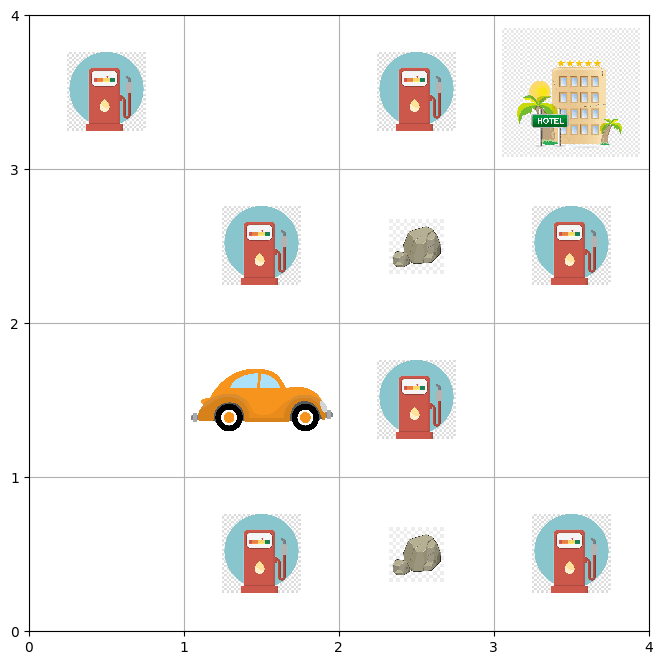

Action taken by the car: Down
The state of the car is: [1 0]
Reward for this step is:  2


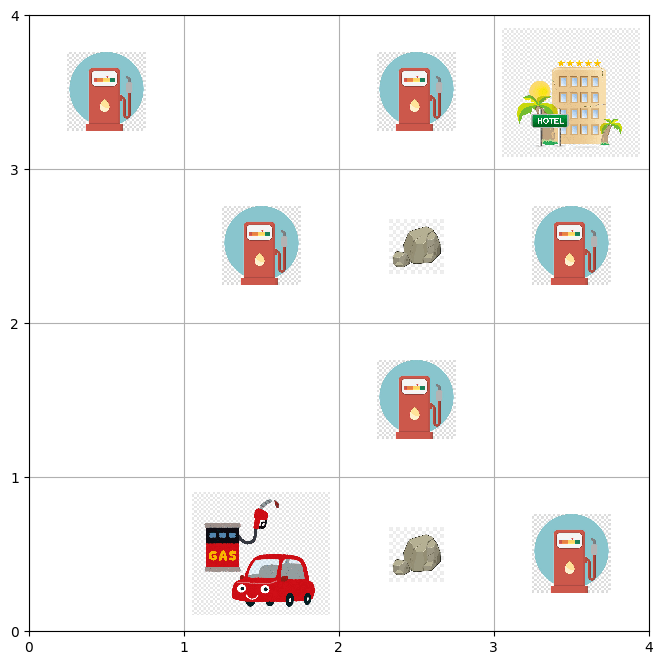

Action taken by the car: Down
The state of the car is: [1 0]
Reward for this step is:  2


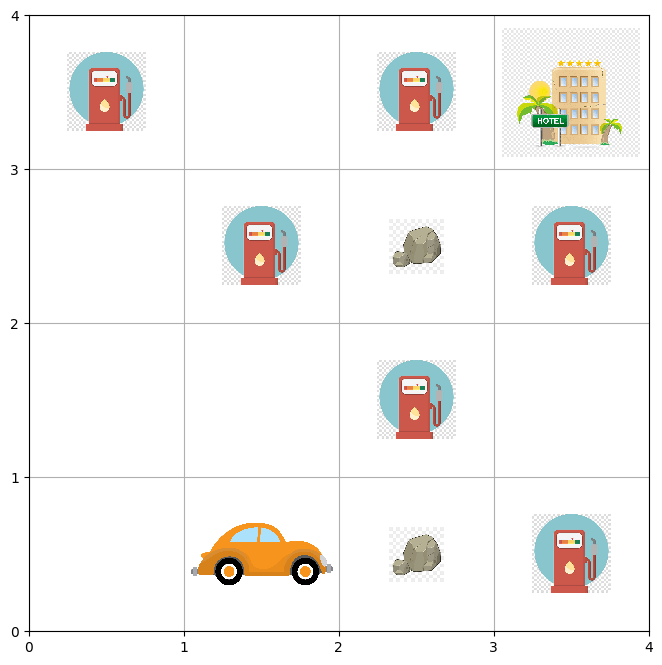

Action taken by the car: Right
The state of the car is: [2 0]
Reward for this step is:  -1
self.car_pos 2 0


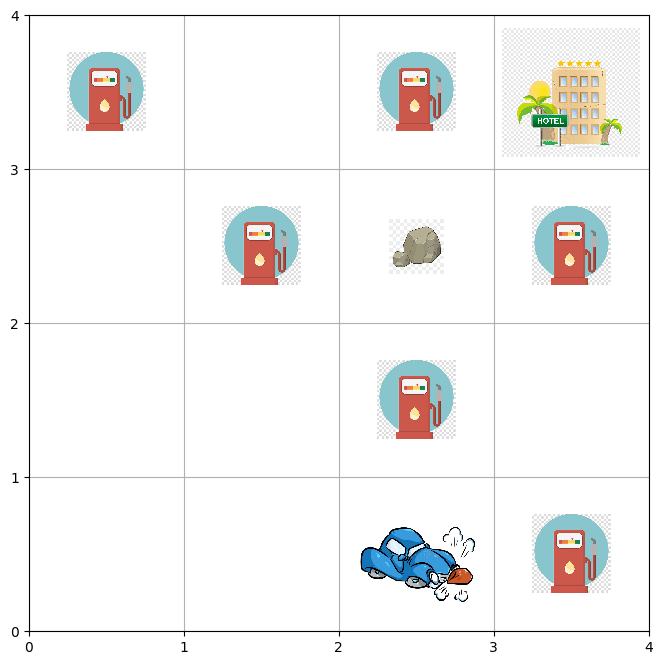

Action taken by the car: Down
The state of the car is: [2 0]
Reward for this step is:  -1


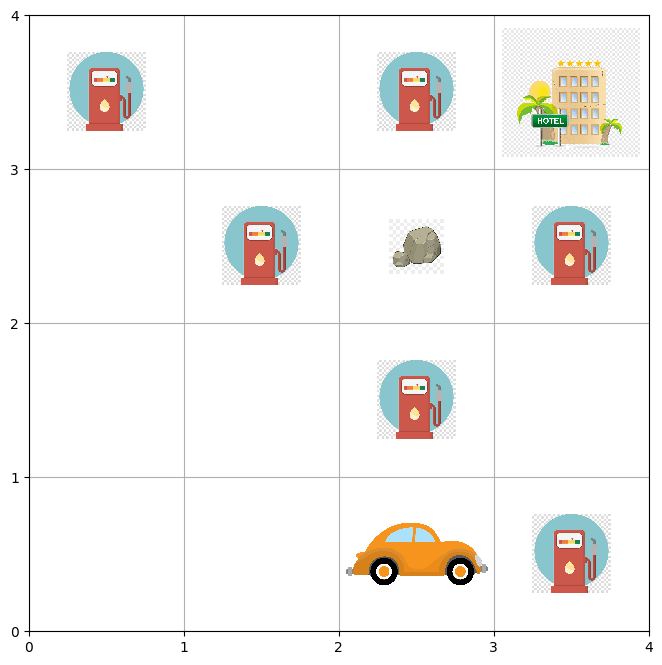

Action taken by the car: Down
The state of the car is: [2 0]
Reward for this step is:  -1


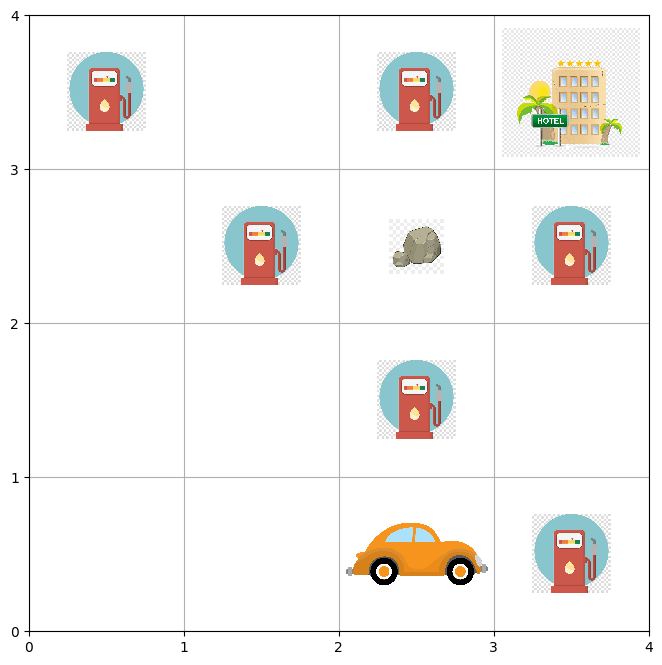

Action taken by the car: Down
The state of the car is: [2 0]
Reward for this step is:  -1


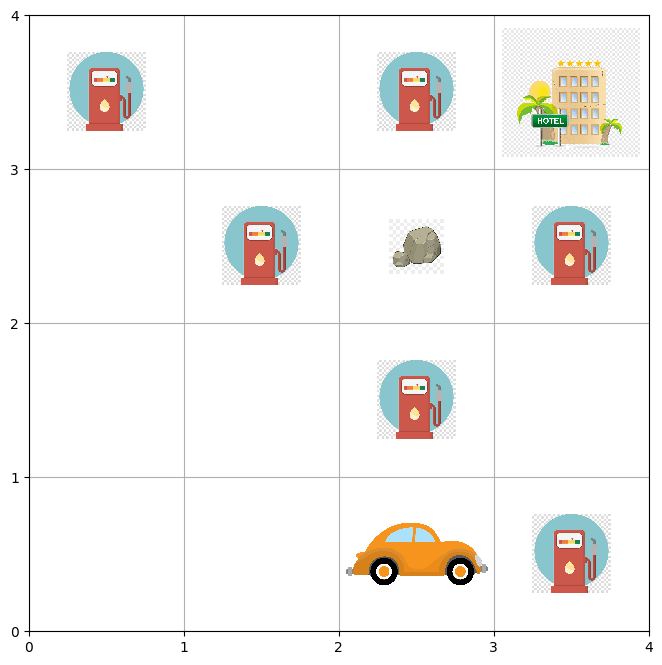

In [ ]:
import random
for i in range(10):
  obs, reward, terminated, truncated= car_move.step(random.choice([0,1,2,3]))
  print("The state of the car is:", obs)
  print("Reward for this step is: ", reward)

  car_move.render(plot=True)

# Part II: Solve your environment using SARSA

In [ ]:
import ast
class SarsaAgent:
    def __init__(self, env, gamma, alpha=0.1, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))


    def choose_action(self, state):

        dict= {'[0 0]': '0', '[0 1]': '1', '[0 2]': '2', '[0 3]': '3', '[1 0]': '4', '[1 1]': '5', '[1 2]': '6',
               '[1 3]': '7', '[2 0]': '8', '[2 1]': '9', '[2 2]': '10', '[2 3]': '11', '[3 0]': '12', '[3 1]': '13', '[3 2]': '14', '[3 3]': '15'}

        stateVal= int(dict[str(state)])


        if np.random.uniform(0, 1) < self.epsilon:
            # Choose a random action
            action = self.env.action_space.sample()
        else:
            # Choose the action with highest Q-value for the current state
            action = np.argmax(self.q_table[stateVal])

        return action

    def update_q_table(self, state, action, reward, next_state, next_action):

        dict= {'[0 0]': '0', '[0 1]': '1', '[0 2]': '2', '[0 3]': '3', '[1 0]': '4', '[1 1]': '5', '[1 2]': '6',
               '[1 3]': '7', '[2 0]': '8', '[2 1]': '9', '[2 2]': '10', '[2 3]': '11', '[3 0]': '12', '[3 1]': '13', '[3 2]': '14', '[3 3]': '15'}

        stateVal= int(dict[str(state)])
        statenextVal = int(dict[str(next_state)])
        #self.q_table[state][action] = self.q_table[state][action]+ (self.alpha * val2)
        self.q_table[stateVal][action] = self.q_table[stateVal][action]+ self.alpha * (reward + self.gamma * self.q_table[statenextVal][next_action]- self.q_table[stateVal][action])
        print(self.q_table)



    def train(self, num_episodes):
        rewards_per_episode = []
        for i in range(num_episodes):
            state = self.env.reset()

            action = self.choose_action(state)
            done = False
            episode_reward = 0

            while not done:
                next_state, reward, done, end= self.env.step(action)
                next_action = self.choose_action(next_state)
                self.update_q_table(state, action, reward, next_state, next_action)

                state = next_state
                action = next_action
                episode_reward += reward

            print(f"EPISODE:{i+1} REWARDS :{episode_reward}")
            rewards_per_episode.append(episode_reward)

        return rewards_per_episode


In [ ]:
car_move1 = ExpeditionEnvironment(environment_type='deterministic')
car_move1.reset()


agent = SarsaAgent(car_move1, 0.1)
rewards_per_episode = agent.train(500)


Streaming output truncated to the last 5000 lines.
 [ 0.          0.          0.          0.        ]
 [15.48201832  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
EPISODE:223 REWARDS :29
Action taken by the car: Up
[[ 0.          2.75697902  0.         31.63832544]
 [ 0.          0.         19.71845955  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [15.48201832  0.          0.

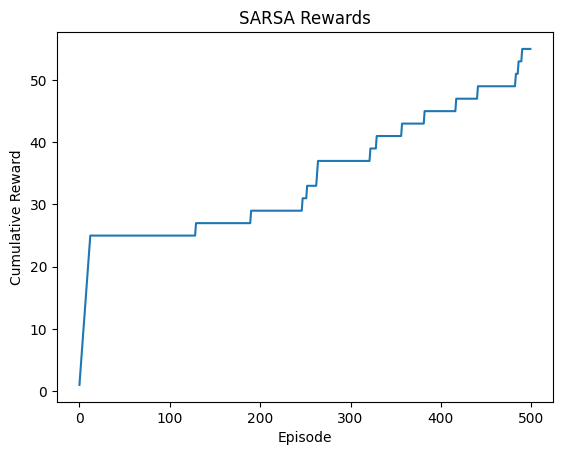

In [ ]:
plt.plot(range(len(rewards_per_episode)), rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('SARSA Rewards')
plt.show()


#Hyperparameter Tuning


1. Discount Factor

Streaming output truncated to the last 5000 lines.
 [ 0.          0.          0.          0.        ]
 [33.19070912 -0.189588    0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-1.31441     0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
EPISODE:223 REWARDS :43
Action taken by the car: Down
[[ 0.         12.57094621  0.         66.35585773]
 [ 0.          0.         16.80308626  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [33.19070912 -0.189588    

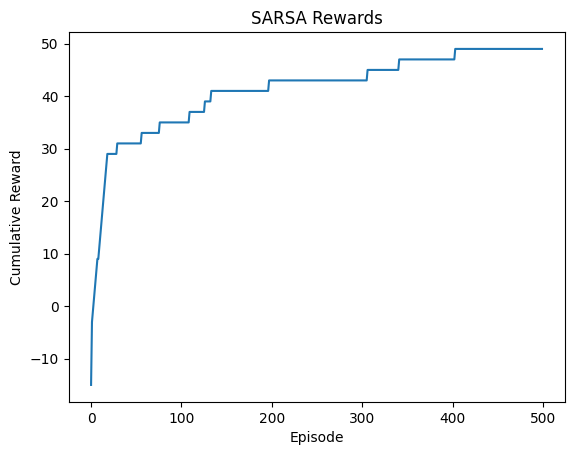

In [ ]:
car_move2 = ExpeditionEnvironment(environment_type='deterministic')
car_move2.reset()


agentDF1 = SarsaAgent(car_move2, 0.4)
rewards_per_episodeDF1 = agentDF1.train(500)


plt.plot(range(len(rewards_per_episodeDF1)), rewards_per_episodeDF1)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('SARSA Rewards')
plt.show()

Streaming output truncated to the last 5000 lines.
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.43505491e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.75180586e+00  0.00000000e+00  0.00000000e+00  1.39830697e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
EPISODE:223 REWARDS :101
Action taken by the car: Down
[[ 0.00000000e+00  5.4

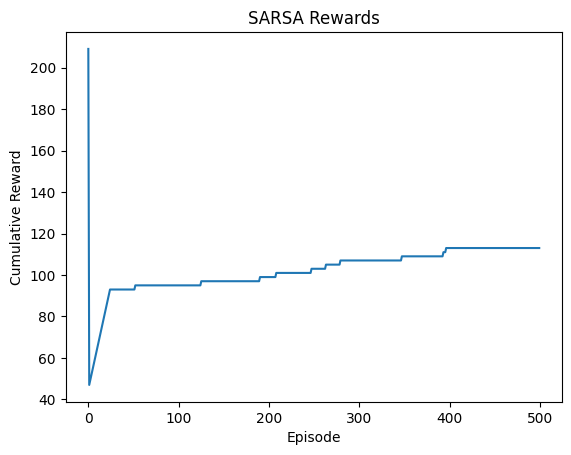

In [ ]:
car_move3 = ExpeditionEnvironment(environment_type='deterministic')
car_move3.reset()

agentDF2 = SarsaAgent(car_move3, 0.2)
rewards_per_episodeDF2 = agentDF2.train(500)


plt.plot(range(len(rewards_per_episodeDF2)), rewards_per_episodeDF2)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('SARSA Rewards')
plt.show()

Streaming output truncated to the last 5000 lines.
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.90359501e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.94331836e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
EPISODE:223 REWARDS :55
Action taken by the car: Down
[[ 0.00000000e+00  6.08

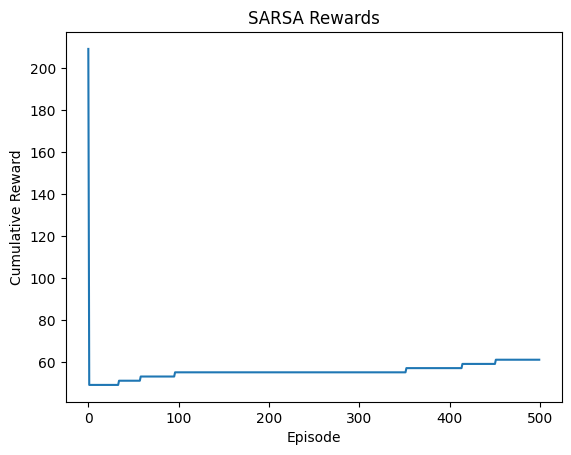

In [ ]:
car_move3 = ExpeditionEnvironment(environment_type='deterministic')
car_move3.reset()

agentD3= SarsaAgent(car_move3, 0.7)
rewards_per_episodeDF3 = agentD3.train(500)


plt.plot(range(len(rewards_per_episodeDF3)), rewards_per_episodeDF3)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('SARSA Rewards')
plt.show()

## 2. Number of Episodes

Action taken by the car: Right
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.2 0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]
Action taken by the car: Right
[[ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.2  0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [-0.1  0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]]
Action taken by the car: Right
[[ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.2  0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [-0.1  0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 

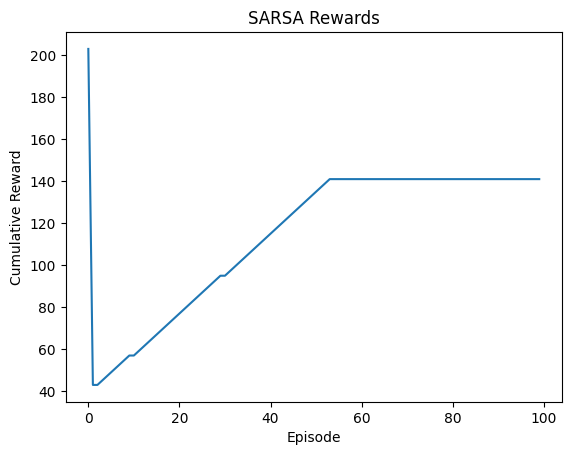

In [ ]:
car_move4 = ExpeditionEnvironment(environment_type='deterministic')
car_move4.reset()

agentE1 = SarsaAgent(car_move4, 0.4)
rewards_per_episodeE1 = agentE1.train(100)


plt.plot(range(len(rewards_per_episodeE1)), rewards_per_episodeE1)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('SARSA Rewards')
plt.show()

Streaming output truncated to the last 5000 lines.
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.07333759e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.00000000e-01  3.80000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.39064438e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
EPISODE:73 REWARDS :100
Action taken by the car: Down
[[ 0.00000000e+00  1.34

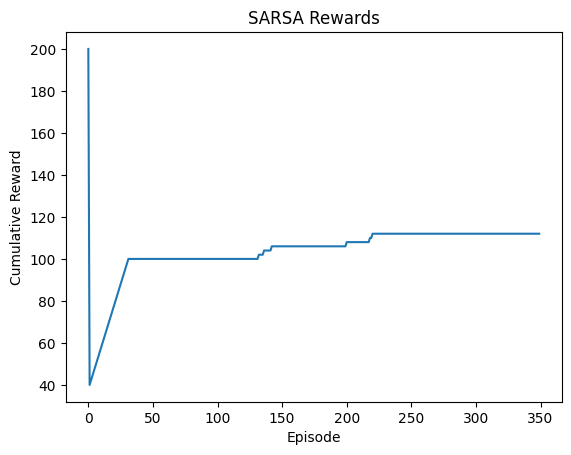

In [ ]:
car_move5 = ExpeditionEnvironment(environment_type='deterministic')
car_move5.reset()

agentE2 = SarsaAgent(car_move5, 0.4)
rewards_per_episodeE2 = agentE2.train(350)


plt.plot(range(len(rewards_per_episodeE2)), rewards_per_episodeE2)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('SARSA Rewards')
plt.show()

Streaming output truncated to the last 5000 lines.
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.85404793e+02 0.00000000e+00 0.00000000e+00 4.08000000e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.19298161e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
EPISODE:523 REWARDS :211
Action taken by the car: Down
[[0.00000000e+00 1.65227591e+02 0.00000000e+00 3.37524149e+02]
 [0.0000000

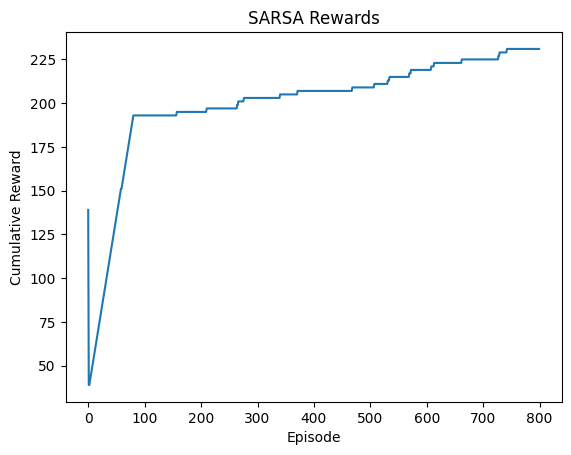

In [ ]:
car_move6 = ExpeditionEnvironment(environment_type='deterministic')
car_move6.reset()

agentE3 = SarsaAgent(car_move6, 0.4)
rewards_per_episodeE3 = agentE3.train(800)


plt.plot(range(len(rewards_per_episodeE3)), rewards_per_episodeE3)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('SARSA Rewards')
plt.show()

#Loading the Q Table

In [ ]:
# Save the Q-table
np.save('/content/drive/MyDrive/images/q_table.npy', agent.q_table)

print("agent q table sarsa :",agent.q_table)

# Load the Q-table
loaded_q_table = np.load('/content/drive/MyDrive/images/q_table.npy')

agent q table sarsa : [[ 0.         34.90270307  0.         58.59025073]
 [ 0.          0.         30.31144659  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [40.26223466  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


#References

https://medium.com/analytics-vidhya/introduction-to-reinforcement-learning-rl-in-pytorch-c0862989cc0e

https://towardsdatascience.com/reinforcement-learning-q-learning-with-illegal-actions-from-scratch-19759146c8bf

https://rubikscode.net/2020/01/20/double-q-learning-python/

https://gamedevacademy.org/an-overview-of-reinforcement-learning-teaching-machines-to-play-games/